In [157]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
# from skimage.util import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight


# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
# ship_dir = '../input'
# train_image_dir = os.path.join(ship_dir, 'train')

In [183]:
import glob

test_img_dir = 'data/test_img'
inputDF = pd.read_csv('data/train_ship_segmentations_v2.csv')

image_names = [f for f in os.listdir(test_img_dir)]

test_DF = inputDF.loc[inputDF['ImageId'].isin(image_names)]

test_DF.head()

,ImageId,EncodedPixels
217189,f000067f0.jpg,NaN
217190,f00087dcd.jpg,NaN
217191,f000c1a04.jpg,NaN
217192,f00189b8c.jpg,NaN
217193,f001dfbd1.jpg,NaN


In [159]:
test_DF.info(())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14534 entries, 217189 to 231722
Data columns (total 2 columns):
ImageId          14534 non-null object
EncodedPixels    5150 non-null object
dtypes: object(2)
memory usage: 340.6+ KB


In [160]:
len(image_names)

12097

In [161]:
12097/105803

0.11433513227413211

In [162]:
test_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14534 entries, 217189 to 231722
Data columns (total 2 columns):
ImageId          14534 non-null object
EncodedPixels    5150 non-null object
dtypes: object(2)
memory usage: 340.6+ KB


In [163]:
masks = test_DF.copy()
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(test_img_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
12018,ffe5664d9.jpg,0,0.0,[0.0],138.075195
11699,ff73ed159.jpg,0,0.0,[0.0],173.620117
10498,fde8bb91d.jpg,0,0.0,[0.0],317.235352
8975,fbdd19d1f.jpg,0,0.0,[0.0],99.674805
1194,f19883fd7.jpg,6,1.0,[1.0],122.165039
605,f0d16afea.jpg,1,1.0,[1.0],120.946289
4648,f624c2434.jpg,0,0.0,[0.0],260.729492


In [164]:
############################## Hyperparameters ######################################

BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False


############################## Utility Functions ######################################

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

############################## END ######################################

############################## Generator to produce input ######################################

def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(test_img_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

                



In [165]:
VALID_IMG_COUNT = 900

test_x, test_y = next(make_image_gen(test_DF, VALID_IMG_COUNT))

In [166]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [167]:
# load json and create model
from keras.models import model_from_json
json_file = open('output/Unet_batch48/model.json', 'r')
loaded_model_json = json_file.read()
# loaded_model_json
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("output/Unet_batch48/seg_model.h5")
print("Loaded model from disk")



Loaded model from disk


In [168]:
import pickle
# with (open("output/bi_acc.p", "rb")) as openfile:
#     bi_acc = pickle.load(openfile)

with open('output/Unet_batch48/epochs.p', 'rb') as fp:
    epochs = pickle.load(fp)
    
with open('output/Unet_batch48/loss_loss.p', 'rb') as fp:
    loss_loss = pickle.load(fp)

with open('output/Unet_batch48/val_loss.p', 'rb') as fp:
    val_loss = pickle.load(fp)

with open('output/Unet_batch48/bi_acc.p', 'rb') as fp:
    bi_acc = pickle.load(fp)

with open('output/Unet_batch48/val_bi_acc.p', 'rb') as fp:
    val_bi_acc = pickle.load(fp)
    


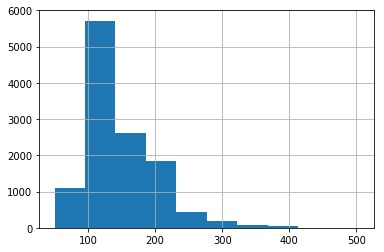

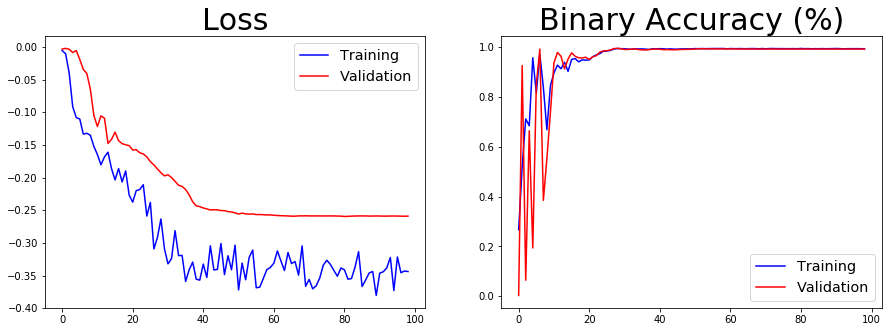

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, loss_loss, 'b-',epochs, val_loss, 'r-')
ax1.legend(['Training', 'Validation'], fontsize = 'x-large')
ax1.set_title('Loss', fontsize=30)
ax2.plot(epochs, bi_acc, 'b-', epochs, val_bi_acc, 'r-')
ax2.legend(['Training', 'Validation'], fontsize = 'x-large')
ax2.set_title('Binary Accuracy (%)', fontsize=30)
fig.savefig('loss_history')
plt.show()

In [170]:
loaded_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])


In [171]:
pred_y = loaded_model.predict(test_x)

pred_y_int = pred_y.astype(np.uint8)

In [172]:
eps=1e-6

inter = np.sum(test_y[4] * pred_y_int[4])
uni = np.sum(test_y[4]) + np.sum(pred_y_int[4]) - inter

IoU_test = (inter + eps) / (uni+eps)
print('The IoU of test image is: {}'.format(IoU_test))

The IoU of test image is: 1.0


In [173]:
eps=1e-6

inter = np.sum(test_y[4] * pred_y_int[4])
uni = np.sum(test_y[4]) + np.sum(pred_y_int[4]) - inter

(inter + eps) / (uni+eps)

1.0

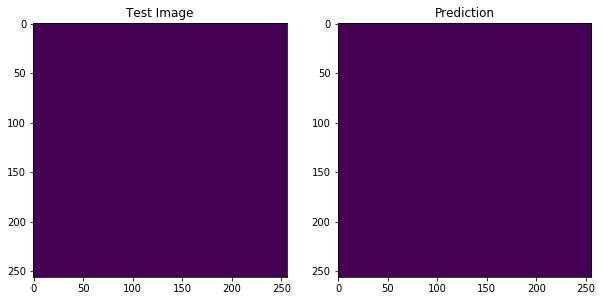

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
# rle_0 = masks.query('test"')['EncodedPixels']
# img_0 = masks_as_image(rle_0)
ax1.imshow(test_y[4][:,:,0])
ax1.set_title('Test Image')
# rle_1 = multi_rle_encode(img_0)
# img_1 = masks_as_image(rle_1)
ax2.imshow(pred_y_int[4][:,:,0])
ax2.set_title('Prediction')
plt.show()

In [175]:
score = loaded_model.evaluate(test_x, test_y)

900/900 [==============================] - 111s   


In [176]:
print('IoU value is: {}'.format(score[0]))
print('Binary accuracy is: {}'.format(score[1]))

IoU value is: -0.5360281952222188
Binary accuracy is: 0.9970566982693142


In [177]:
masks = pd.read_csv(os.path.join('data/train_ship_segmentations_v2.csv'))
train_image_dir = 'data/train_v2'
images_with_ship = test_DF.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 2713 image files with masks


Image f0020e8ba.jpg
Found bbox (50, 21, 103, 75)
Found bbox (354, 47, 421, 108)


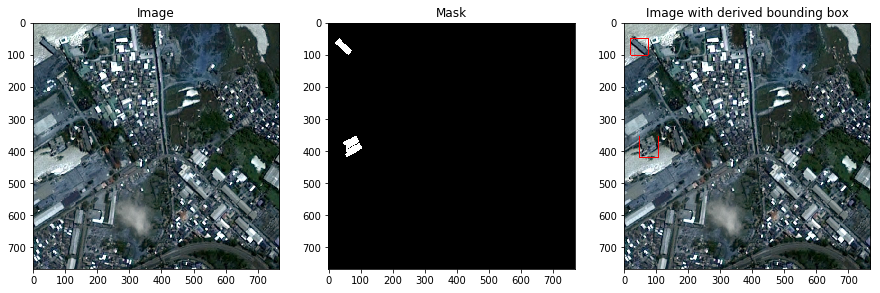

Image f00359b99.jpg
Found bbox (549, 0, 589, 217)


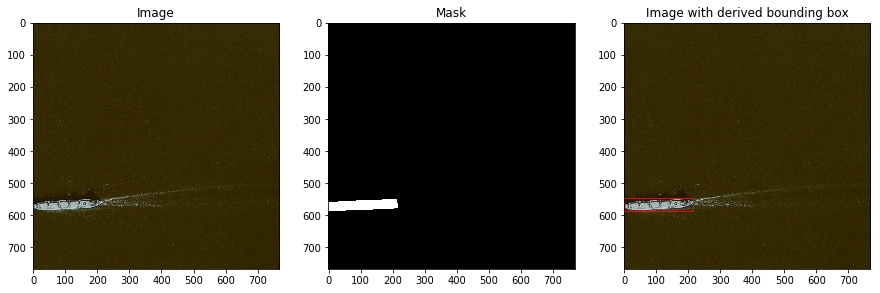

Image f0041df39.jpg
Found bbox (292, 256, 301, 270)


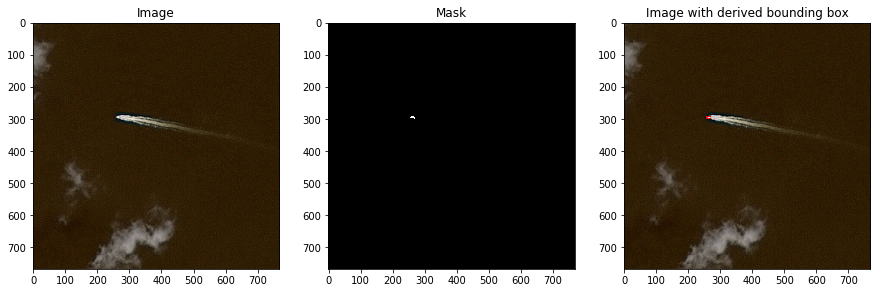

Image f005933d5.jpg
Found bbox (6, 282, 11, 287)


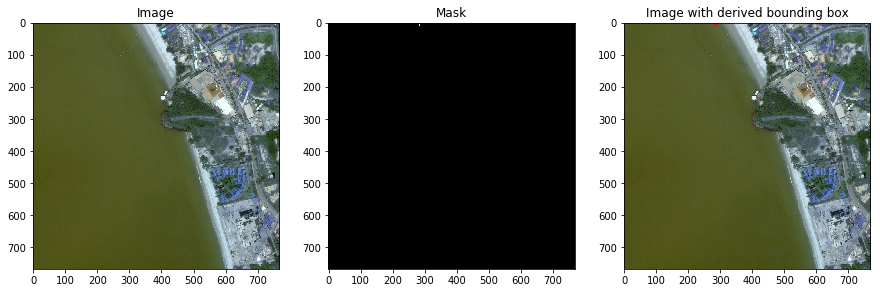

Image f00b69fa9.jpg
Found bbox (691, 44, 732, 237)


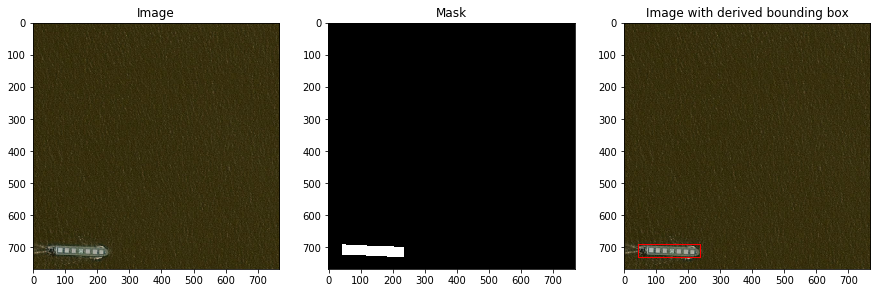

Image f00bf182a.jpg
Found bbox (101, 729, 113, 739)


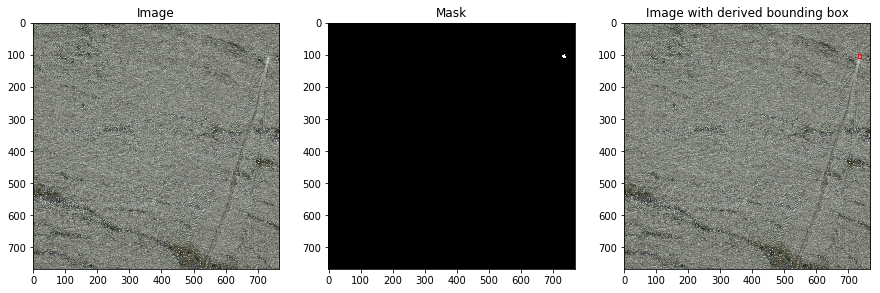

Image f00c26083.jpg
Found bbox (694, 337, 768, 371)


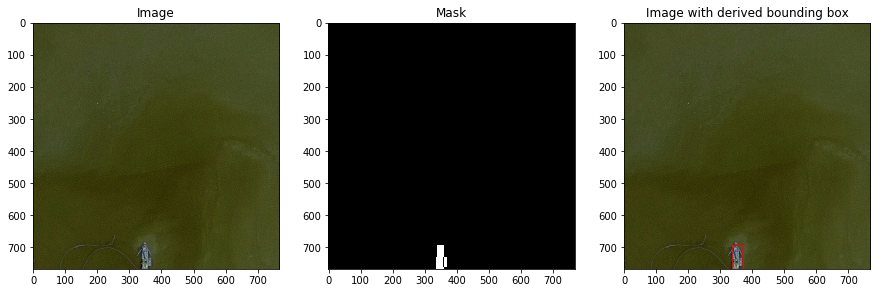

Image f0108ca49.jpg
Found bbox (578, 320, 593, 335)
Found bbox (733, 416, 739, 431)


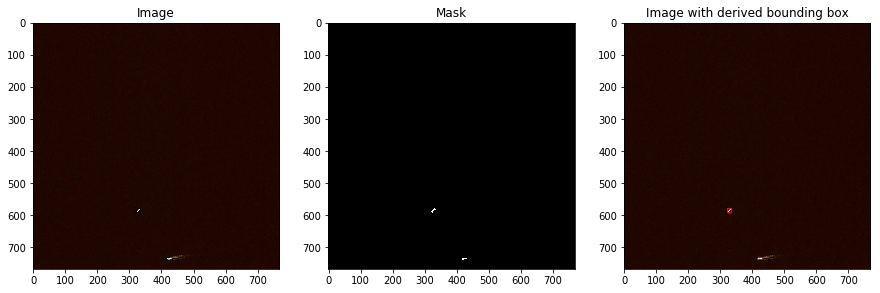

Image f0112c087.jpg
Found bbox (422, 713, 496, 737)


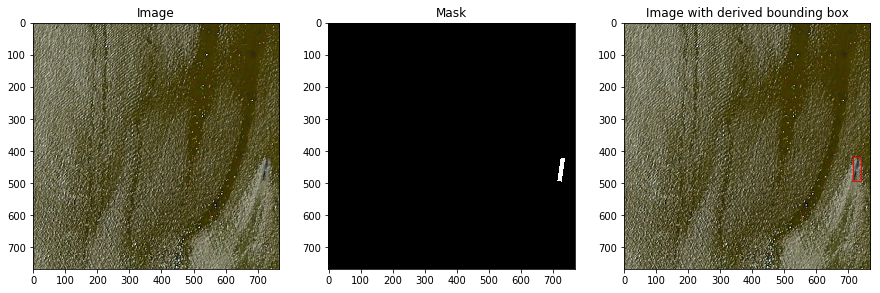

Image f011478e5.jpg
Found bbox (474, 426, 497, 452)


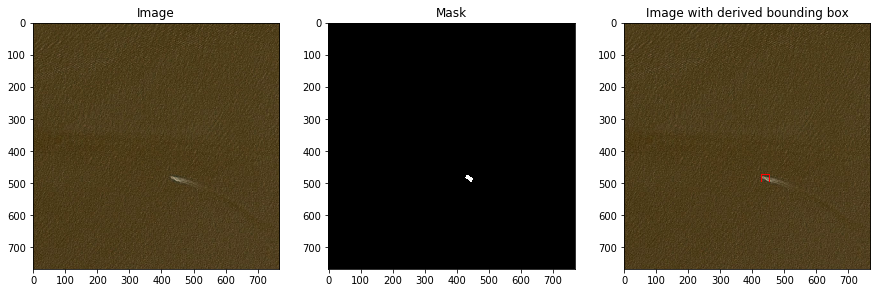

In [178]:
import cv2
from skimage.measure import label, regionprops

##### original img bounding box

for i in range(10):
    image = images_with_ship[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(test_img_dir+'/' + image)
    rle_0 = test_DF.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    #ax2.imshow(mask_0[...,0], cmap='gray')
    ax2.imshow(mask_0,cmap='gray')
    ax3.imshow(img_1)
    plt.show()

Found bbox (4, 146, 19, 162)
Found bbox (4, 230, 21, 252)
Found bbox (65, 138, 128, 187)
Found bbox (248, 14, 250, 20)


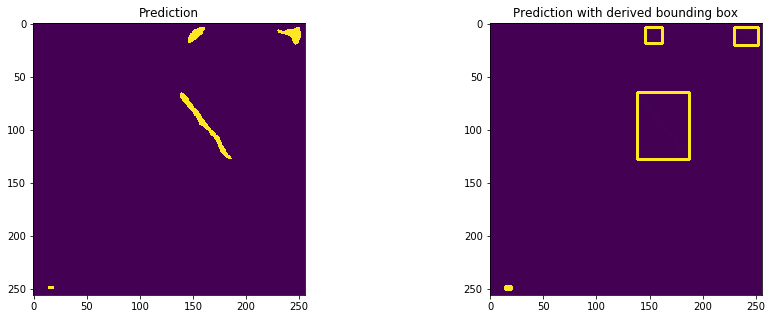

In [179]:
####### prediction bounding box
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
pre_0 = pred_y_int[0][:,:,0]
lbl_0 = label(pre_0) 
props = regionprops(lbl_0)
pre_1 = pre_0.copy()

for prop in props:
    print('Found bbox', prop.bbox)
    cv2.rectangle(pre_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


ax1.imshow(pre_0)
ax1.set_title('Prediction')
ax2.set_title('Prediction with derived bounding box')
ax2.imshow(pre_1)
plt.show()

In [185]:
tmp_DF = test_DF.copy()

In [187]:
sample_image = ['f00359b99.jpg', 'f00b69fa9.jpg']
tmp_DF = tmp_DF.loc[tmp_DF['ImageId'].isin(sample_image)]
tmp_DF

,ImageId,EncodedPixels
217203,f00359b99.jpg,561 22 1329 29 2097 29 2865 29 3633 29 4401 29...
217222,f00b69fa9.jpg,34500 16 35252 32 36020 32 36788 32 37556 32 3...


In [188]:
temp_x, temp_y = next(make_image_gen(tmp_DF, 2))

In [190]:
pred_temp_y = loaded_model.predict(temp_x)

pred_temp_y_int = pred_temp_y.astype(np.uint8)

Found bbox (182, 6, 196, 90)
Found bbox (189, 107, 190, 109)


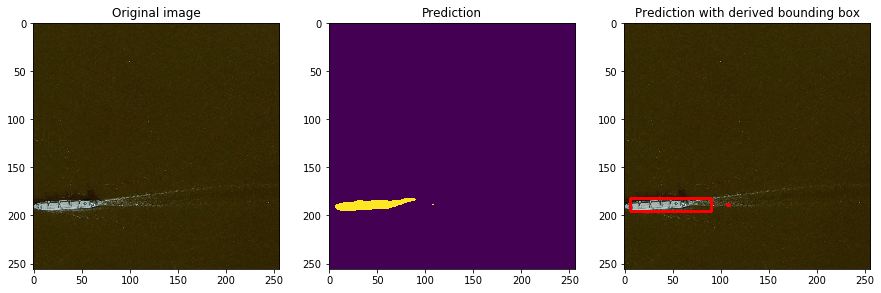

In [197]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
img_0 = cv2.imread(test_img_dir+'/' + 'f00359b99.jpg')
img_0 = img_0[::3, ::3]
pre_0 = pred_temp_y_int[0][:,:,0]
lbl_0 = label(pre_0) 
props = regionprops(lbl_0)
pre_1 = img_0.copy()

for prop in props:
    print('Found bbox', prop.bbox)
    cv2.rectangle(pre_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)

ax1.imshow(img_0)
ax1.set_title('Original image')
ax2.imshow(pre_0)
ax2.set_title('Prediction')
ax3.set_title('Prediction with derived bounding box')
ax3.imshow(pre_1)
plt.show()

Found bbox (232, 20, 243, 76)


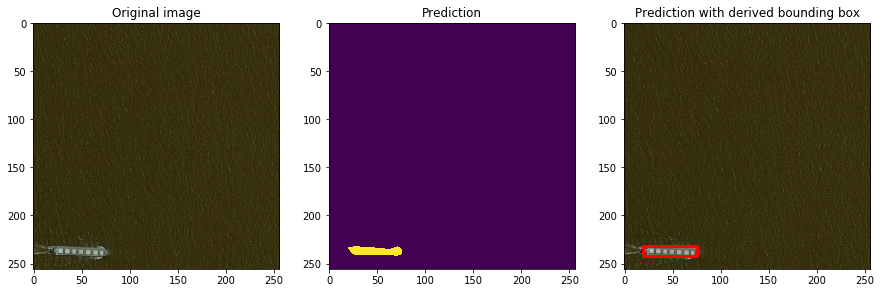

In [201]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
img_0 = cv2.imread(test_img_dir+'/' + 'f00b69fa9.jpg')
img_0 = img_0[::3, ::3]
pre_0 = pred_temp_y_int[1][:,:,0]
lbl_0 = label(pre_0) 
props = regionprops(lbl_0)
pre_1 = img_0.copy()

for prop in props:
    print('Found bbox', prop.bbox)
    cv2.rectangle(pre_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)

ax1.imshow(img_0)
ax1.set_title('Original image')
ax2.imshow(pre_0)
ax2.set_title('Prediction')
ax3.set_title('Prediction with derived bounding box')
ax3.imshow(pre_1)
plt.show()